In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from scipy.stats import unitary_group
from itertools import combinations
import matplotlib.pyplot as plt
import scienceplots
from scipy.optimize import minimize
from IPython.display import clear_output

plt.style.use(['ieee', 'no-latex'])

In [2]:
n = 4
na = 2
n_tot = n + na
T = 30
L = 12
Ndata = 100
Nparams = 2 * L * n_tot

### Diffusion Model

In [3]:
def tfim(n, g):
    # hamiltonian matrix of tfim
    x = np.array([[0, 1], [1, 0]])
    z = np.array([[1,0], [0, -1]])
    zz = np.kron(z, z)
    h = 0
    for i in range(n-1):
        h -= np.kron(np.kron(np.eye(2**i), zz), np.eye(2**(n-2-i)))
    for i in range(n):
        h -= g* np.kron(np.kron(np.eye(2**i), x), np.eye(2**(n-1-i)))
    return h

In [4]:
def magnetization(state, n):
    M = 0
    for i in range(2**n):
        basis_M = 0.
        basis = (bin(i)[2:]).zfill(4)
        for spin in basis:
            basis_M += (np.abs(state[i])**2 * (2*int(spin)-1))
        basis_M /= n
        if np.abs(basis_M) <= 1:
            M += np.abs(basis_M)
        else:
            print("the basis mag is wrong")
    return M

In [5]:
def haarSample(Ndata, seed):
    np.random.seed(seed)
    states_T = [unitary_group.rvs(2**n)[:, 0] for _ in range(Ndata)]
    return states_T

In [6]:
def diffusionCircuit(t, input_state, phis, gs=None):
    qc = QuantumCircuit(n)

    state = Statevector(input_state)

    # Apply the parameterized gates
    for tt in range(t):
        for i in range(n):
            qc.rz(phis[3 * n * tt + i], i)
            qc.ry(phis[3 * n * tt + n + i], i)
            qc.rz(phis[3 * n * tt + 2 * n + i], i)
        if n >= 2 and gs is not None:
            for i, j in combinations(range(n), 2):
                qc.rzz(gs[tt] / (2 * np.sqrt(n)), i, j)
    
    state = state.evolve(qc)
    return state

In [7]:
def diffusionData(t, inputs, diff_hs, seed):

    np.random.seed(seed) 

    phis = (np.random.rand(Ndata, 3 * n * t) * np.pi / 4 - np.pi / 8) * diff_hs.repeat(3 * n)
    if n > 1:
        gs = (np.random.rand(Ndata, t) * 0.2 + 0.4) * diff_hs
    else:
        gs = None

    states = np.zeros((Ndata, 2**n), dtype=np.complex128)

    for i in range(Ndata):
        states[i] = diffusionCircuit(t, inputs[i], phis[i], gs[i] if gs is not None else None).data

    return states

In [8]:
# Generate diffusion data set
diff_hs = np.linspace(0.1, 2., T)
gs = np.random.uniform(0.2,0.4,Ndata)

X = []
for g in gs:
    _, vecs = np.linalg.eigh(tfim(n, g))
    X.append(vecs[:, 0])

S = np.zeros((T + 1, Ndata, 2**n), dtype=np.complex64)
S[0] = X

for t in range(1, T + 1):
    S[t] = diffusionData(t, X, diff_hs[:t], seed=t)

### Denoising Model

In [9]:
def randomMeasure(input_state):
    reshaped = input_state.reshape(2**na, 2**n)
    m_probs = np.sum(np.abs(reshaped)**2, axis=1)  # probabilities of ancilla states
    m_probs = m_probs / np.sum(m_probs)

    m_res = np.random.choice(len(m_probs), p=m_probs)  # Measure and select an ancilla state
    indices = 2**n * m_res + np.arange(2**n)  # Index of post-measurement state

    post_state = input_state[indices]  # Select the corresponding post-measurement state

    norm = np.linalg.norm(post_state)
    if norm == 0:
        norm = 1 

    normalized_state = post_state / norm
    return normalized_state

In [10]:
def denoisingLayer(input_state, params, n_tot, L):
  
    state = Statevector(input_state)

    qc = QuantumCircuit(n_tot)

    # Apply layers of gates
    for l in range(L):
        for i in range(n_tot):
            qc.rx(params[2 * n_tot * l + i], i)
            qc.ry(params[2 * n_tot * l + n_tot + i], i)
        for i in range(n_tot // 2):
            qc.cz(2 * i, 2 * i + 1)
        if n_tot % 2 == 1: 
            qc.cz(n_tot - 2, n_tot - 1)

    state = state.evolve(qc)

    return randomMeasure(state.data)

In [11]:
anc = np.zeros(2**na)
anc[0] = 1

In [12]:
def denoisingFull(input_state, params, n_tot, L, t):
    '''
    SINGLE STATE, RETURN FINAL STATE AFTER MEASUREMENT (N_TOT QUBITS)
    '''
    x = []
    x.append(input_state) 
    for t in range(T,t-1,-1):
        p = params[(T-t) * Nparams : (T-t+1) * Nparams]
        outcome = denoisingLayer(x[-1], p, n_tot, L)
        x.append(np.kron(outcome[outcome!=0], anc))
    return x[-1]

In [13]:
ApproxS = [None] * (T+1)
ApproxS[-1] = haarSample(Ndata,seed=22)

In [14]:
def maxMeanDiscripency(set1, set2):
    set1 = np.array(set1, dtype=np.complex128)
    set2 = np.array(set2, dtype=np.complex128)
    
    r11 = 1 - np.mean(np.abs(set1 @ set1.conj().T)**2)
    r22 = 1 - np.mean(np.abs(set2 @ set2.conj().T)**2)
    r12 = 1 - np.mean(np.abs(set1 @ set2.conj().T)**2)
    return 2 * r12 - r11 - r22

In [15]:
ancilla = np.zeros(2**na)
ancilla[0] = 1
loss_hist = []

theta = np.random.uniform(0,2*np.pi, T * Nparams)

def costFunction(params, t):
    output = []
    ApproxS[t-1] = []
    for i in range(Ndata):
        input = np.kron(ApproxS[T][i], ancilla)
        input = input / np.linalg.norm(input)
        temp = denoisingFull(input, np.array(theta[0: (T-t+1) * Nparams]), n_tot, L, t+1)
        output.append(denoisingLayer(temp, np.array(params), n_tot, L))
        output[i] = output[i] / np.linalg.norm(output[i])
        ApproxS[t-1].append(output[i][output[i]!=0])

    cost = maxMeanDiscripency(ApproxS[t-1], S[t-1])
    loss_hist.append(cost)

    # Clear output and update the real-time plot
    clear_output(wait=True)
    plt.xlabel("Training Step")
    plt.yscale("log")
    plt.ylabel(r"$\mathcal{D}_{\text{MMD}} (\tilde{\mathcal{S}}_t, \mathcal{S}_t)$")
    plt.plot(range(len(loss_hist)), loss_hist)
    plt.title(f"Current Step: {t}")
    plt.show()

    return cost

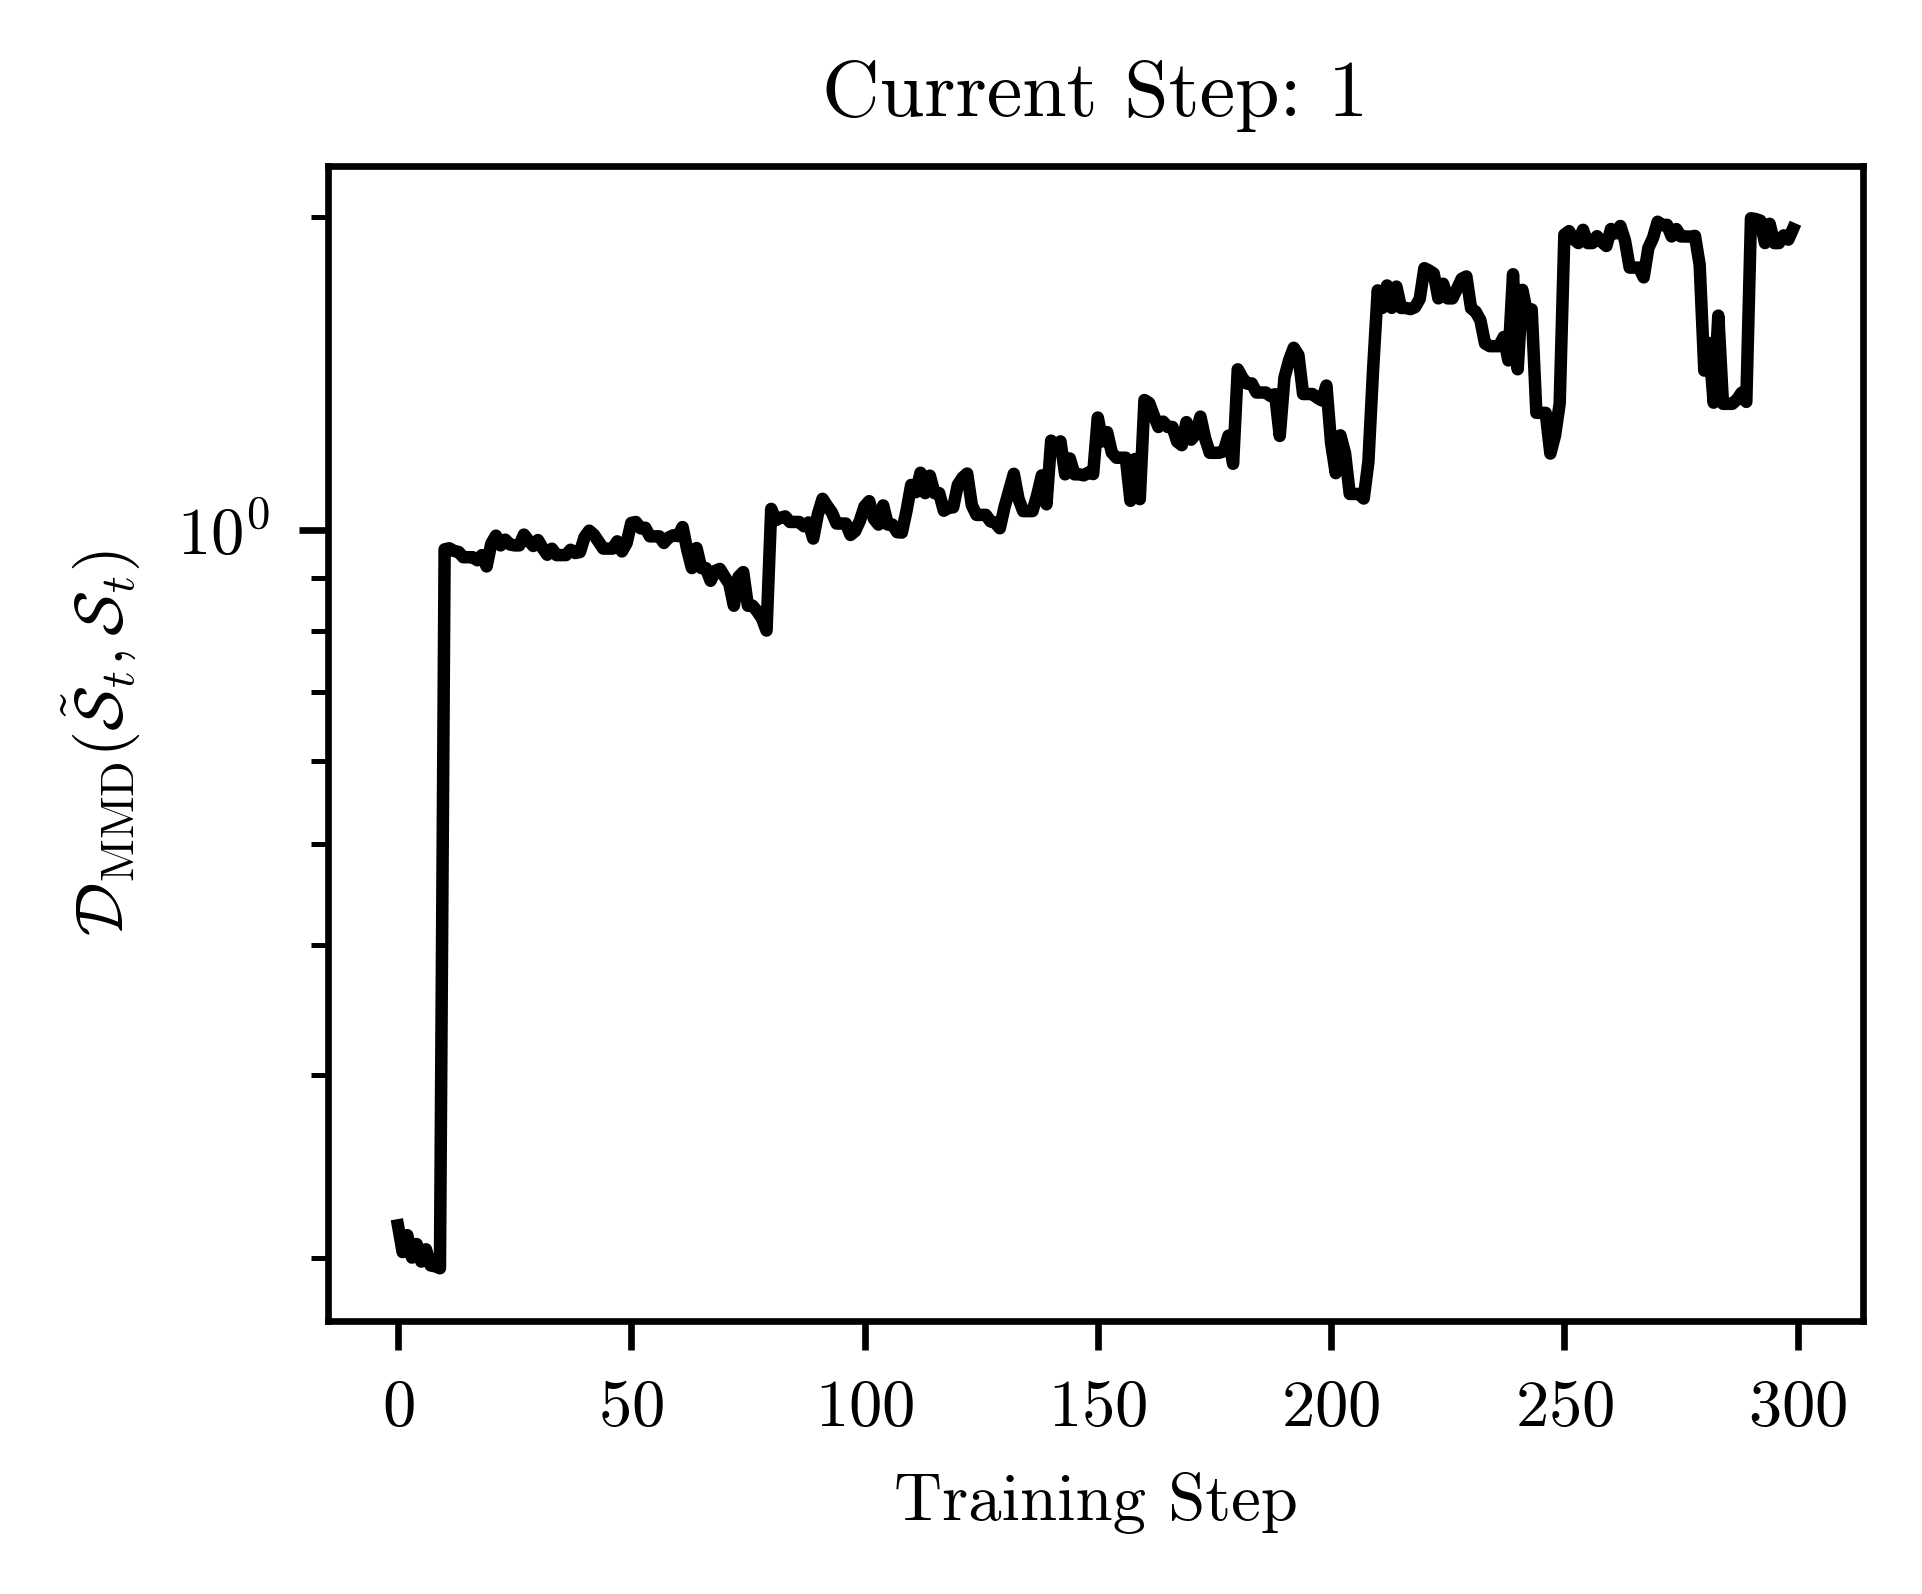

In [16]:

for k in np.arange(T,0,-1):
    result = minimize(
        costFunction,
        theta[(T-k) * Nparams : (T-k+1) * Nparams],
        args=(k,),
        method="COBYLA",
        options={"maxiter": 10},
    )

    theta[ (T-k) * Nparams : (T-k+1) * Nparams] = result.x

/var/folders/z8/g5m0xfqn4nx8cgfn199lgfq40000gn/T/ipykernel_62883/3426732007.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  secax.set_xticklabels(np.arange(T+5,-1,-5))


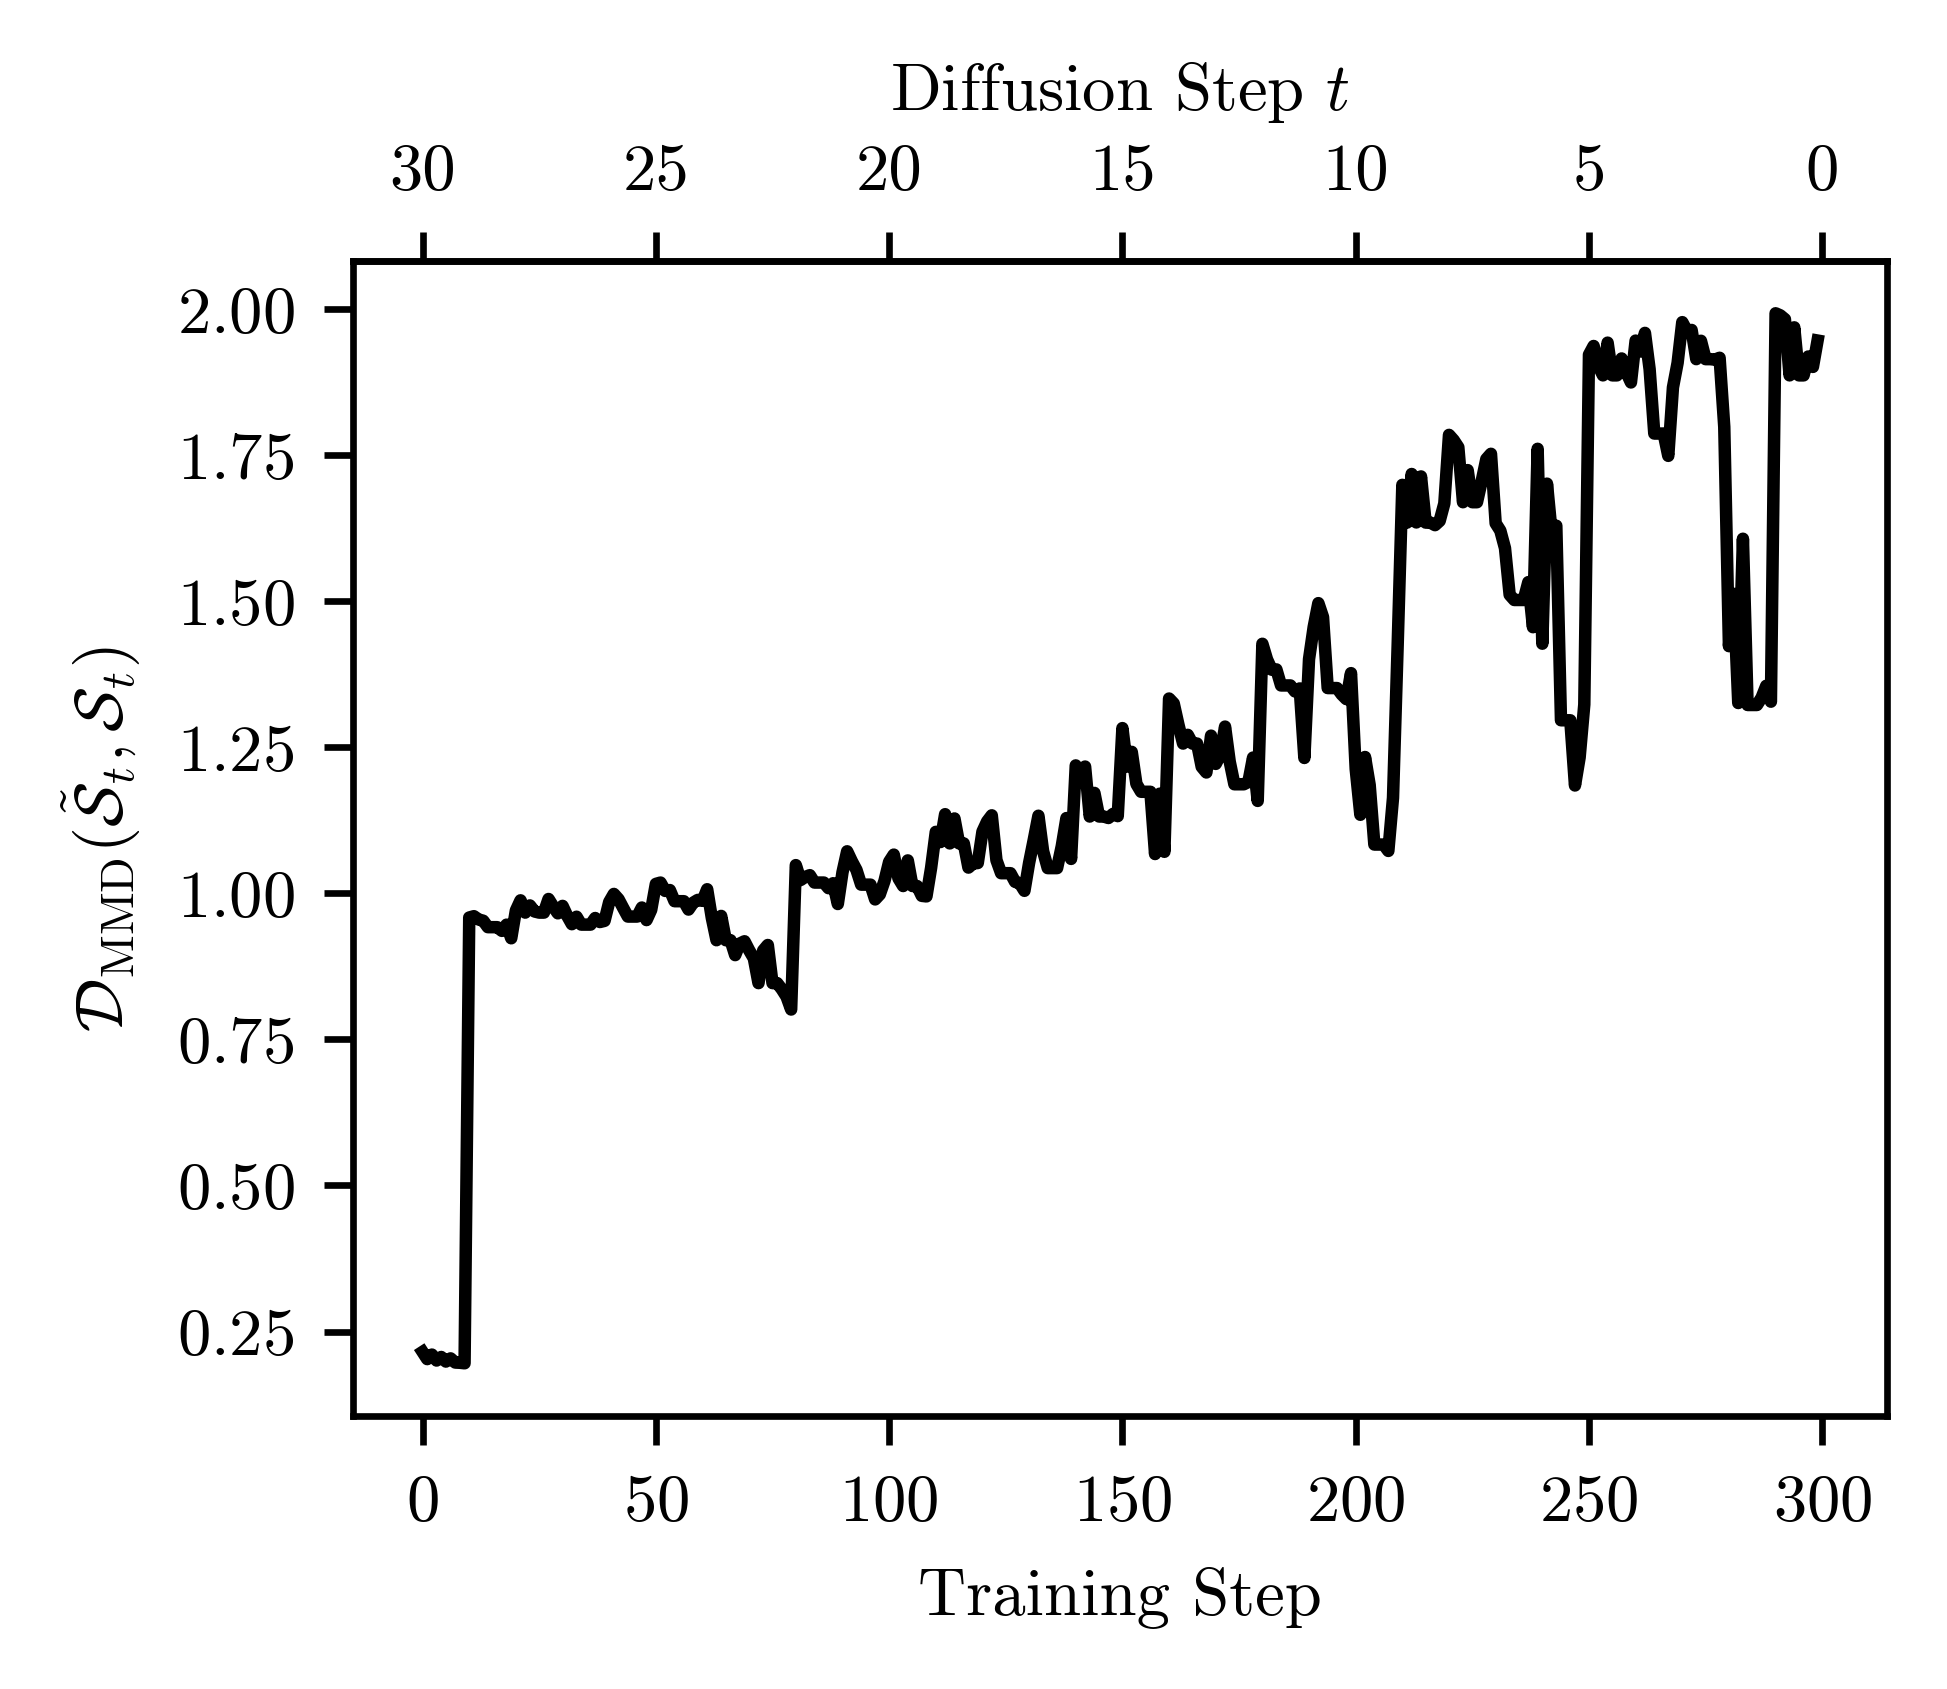

In [17]:
plt.xlabel("Training Step")
#plt.yscale('log')
plt.ylabel(r'$\mathcal{D}_{\text{MMD}} (\tilde{\mathcal{S}}_t, \mathcal{S}_t)$')
plt.plot(range(len(loss_hist)), loss_hist)

secax = plt.gca().secondary_xaxis('top')
secax.set_xlabel(fr"Diffusion Step $t$")
secax.set_xticklabels(np.arange(T+5,-1,-5))
#plt.savefig('Final-Clustering-Loss-1000epochs.pdf', bbox_inches='tight')
plt.show()

### Testing and Visualisation

In [18]:
testS = [None] * (T+1)

testS[T] = haarSample(Ndata, seed=24)

for t in range(T,0,-1):
    testS[t-1] = []
    for i in range(Ndata):
        input = np.kron(testS[T][i], ancilla)
        input = input / np.linalg.norm(input)
        temp = denoisingFull(input, np.array(theta[0: (T-t+1) * Nparams]), n_tot, L, t)
        testS[t-1].append(temp[temp!=0])

NameError: name 'Bloch' is not defined

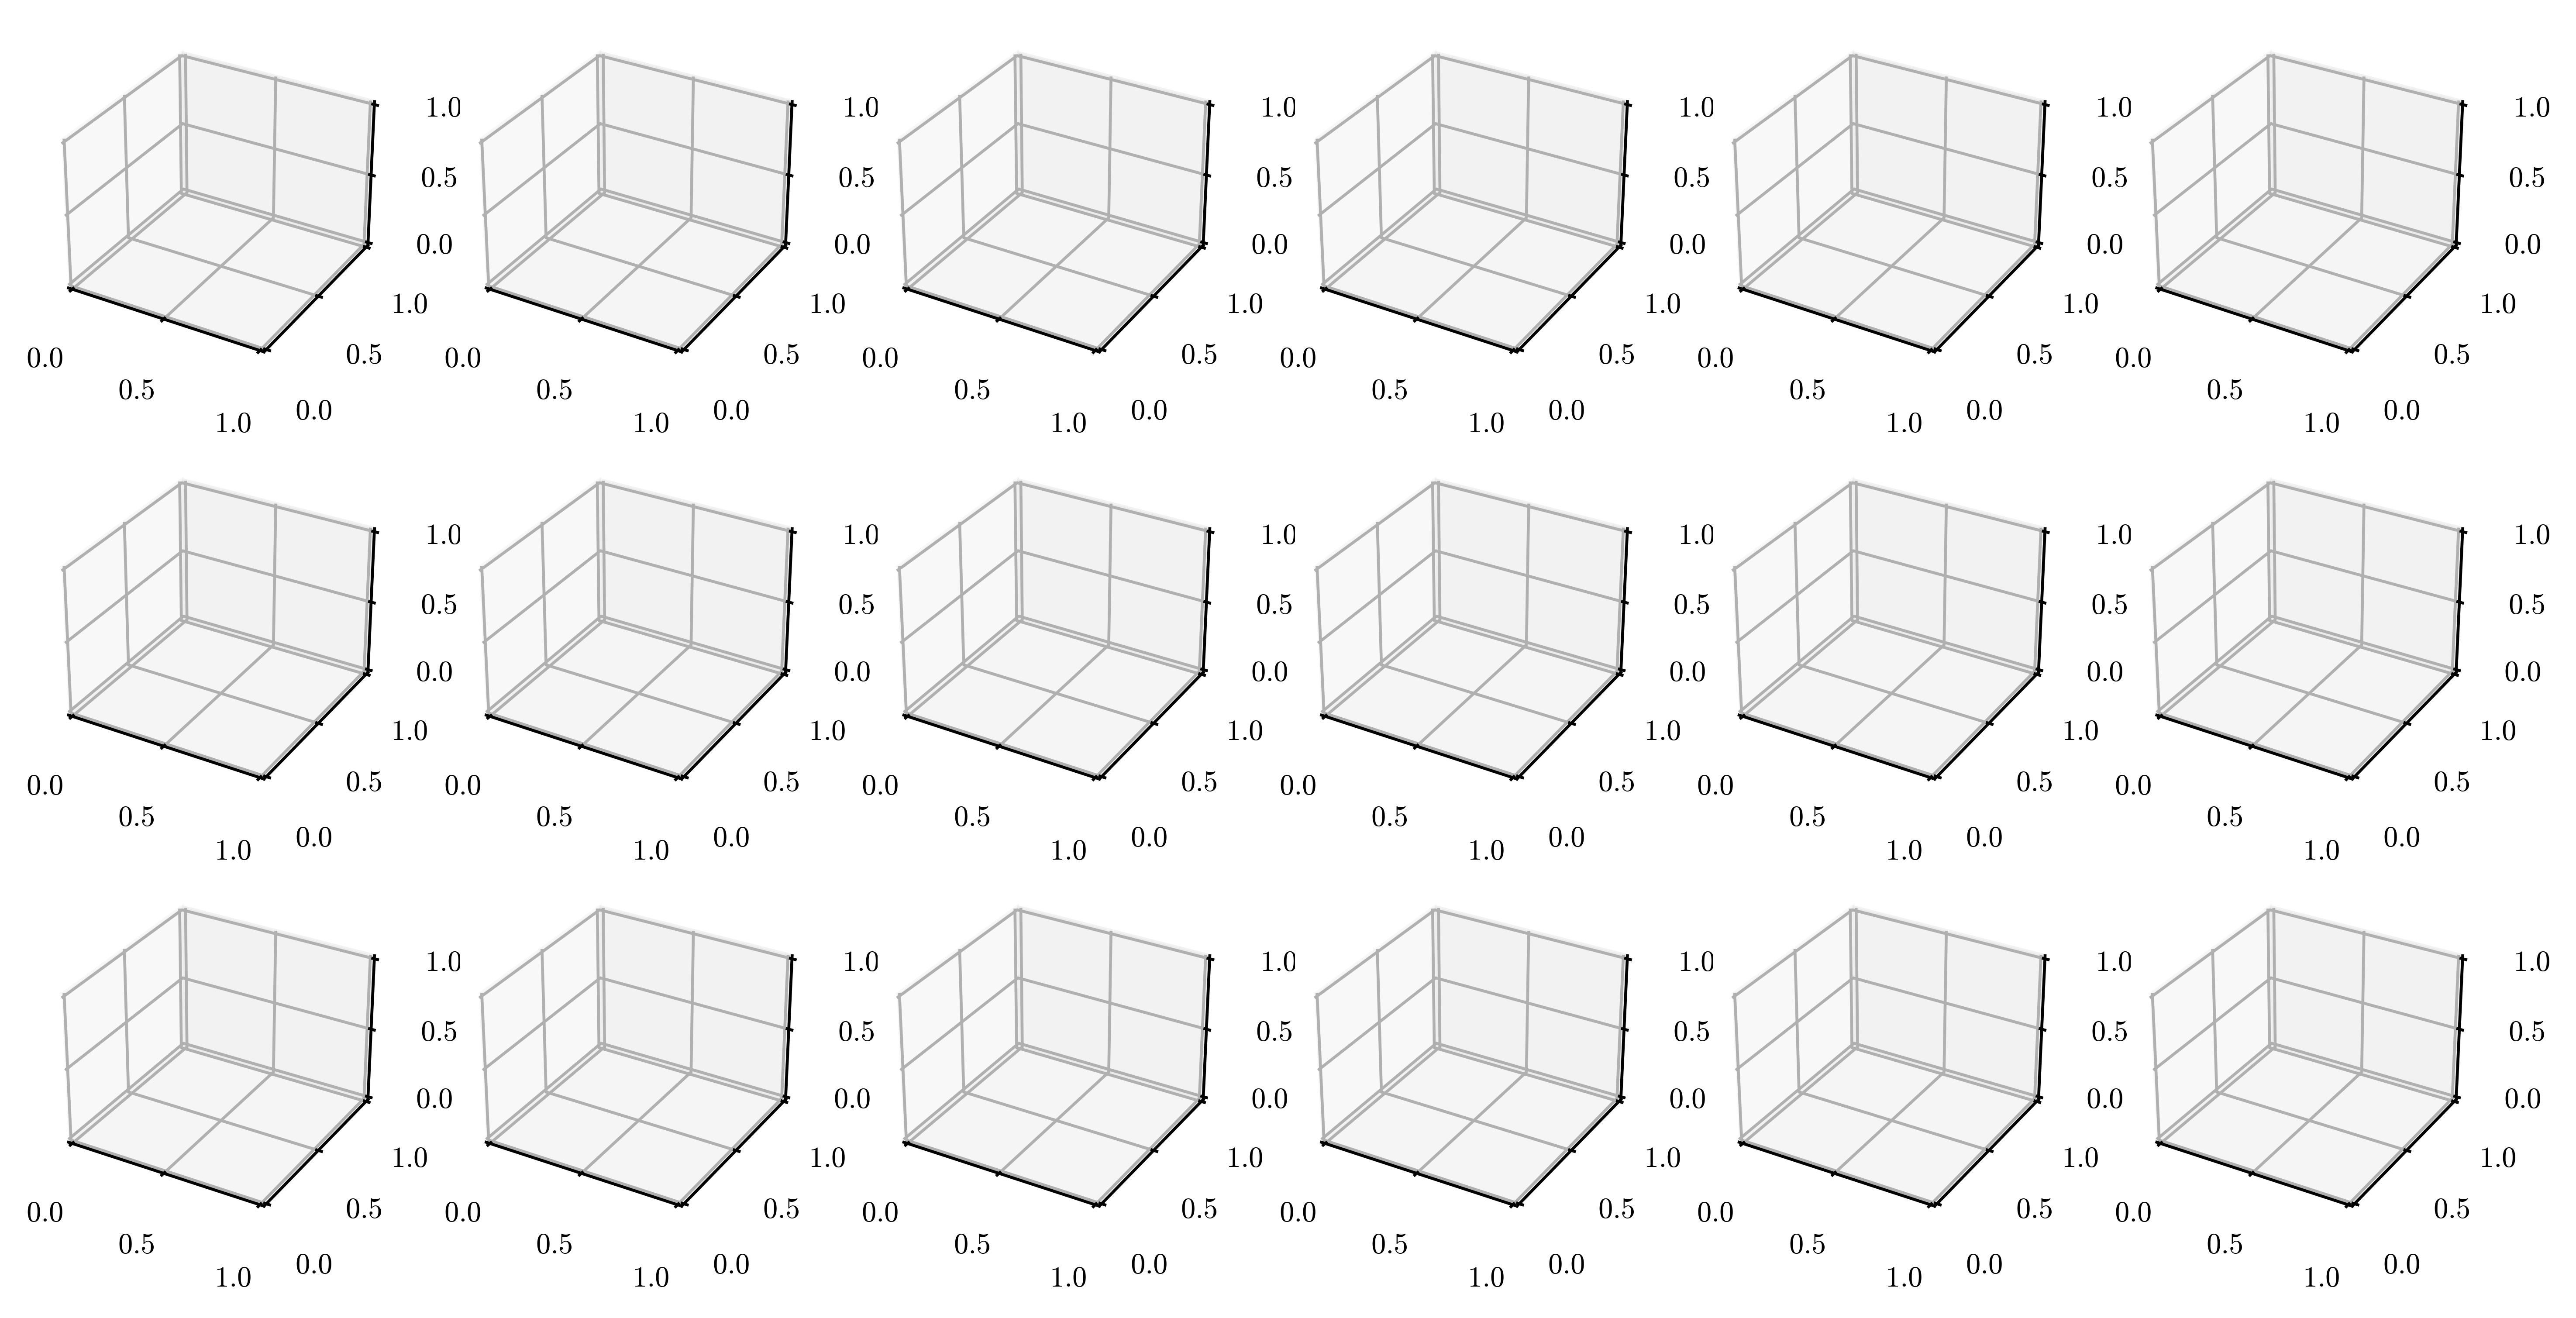

In [19]:
time_steps = [0,5,10,15,19,20]
fig, axs = plt.subplots(3, len(time_steps), subplot_kw={'projection': '3d'}, figsize=( 2 * len(time_steps), len(time_steps)))

for idx, t in enumerate(time_steps):
    b0 = Bloch(axes=axs[0,idx])
    b1 = Bloch(axes=axs[1,idx])
    b2 = Bloch(axes=axs[2,idx])
    for i in range(Ndata):
        b0.add_points(stateToBloch(S[t][i]))
        b0.point_color = ['r']
        b0.point_size = [3]
        b0.frame_alpha = 0.1
        b0.sphere_alpha = 0.1
        b0.point_marker = ['s']

        b1.add_points(stateToBloch(ApproxS[t][i]))
        b1.point_color = ['b']
        b1.point_size = [3]
        b1.frame_alpha = 0.1
        b1.sphere_alpha = 0.1
        b1.point_marker = ['s']

        b2.add_points(stateToBloch(testS[t][i]))
        b2.point_color = ['g']
        b2.point_size = [3]
        b2.frame_alpha = 0.1
        b2.sphere_alpha = 0.1
        b2.point_marker = ['s']

    b0.render()
    b1.render()
    b2.render()
    axs[0,idx].set_title(f"t = {t}", loc='left')

#plt.savefig('Final-Clustering-BlochSpheres-1000epochs.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(T+1), [0.5] * (T+1), 'k--')
ApproxS = np.array(ApproxS)
testS = np.array(testS)

ax.plot(range(T+1), np.mean(np.abs(S[:,:,0])**2, axis=1), 'ro-', label=r'Diffusion')
ax.plot(range(T+1), np.mean(np.abs(ApproxS[:,:,0])**2, axis=1), 'bo-', label=r'Training')
ax.plot(range(T+1), np.mean(np.abs(testS[:,:,0])**2, axis=1), 'go-', label=r'Testing')
ax.set_ylabel(r'$F_0$')
ax.set_xlabel(r'$t$')
ax.legend(loc= 'best')
#plt.savefig('Final-Clustering-Fidelity-1000epochs.pdf', bbox_inches='tight' )
plt.show()

Text(0, 0.5, '$\\mathcal{D}_{\\rm MMD}(\\tilde{\\mathcal{S}}_t, \\mathcal{E}_0)$')

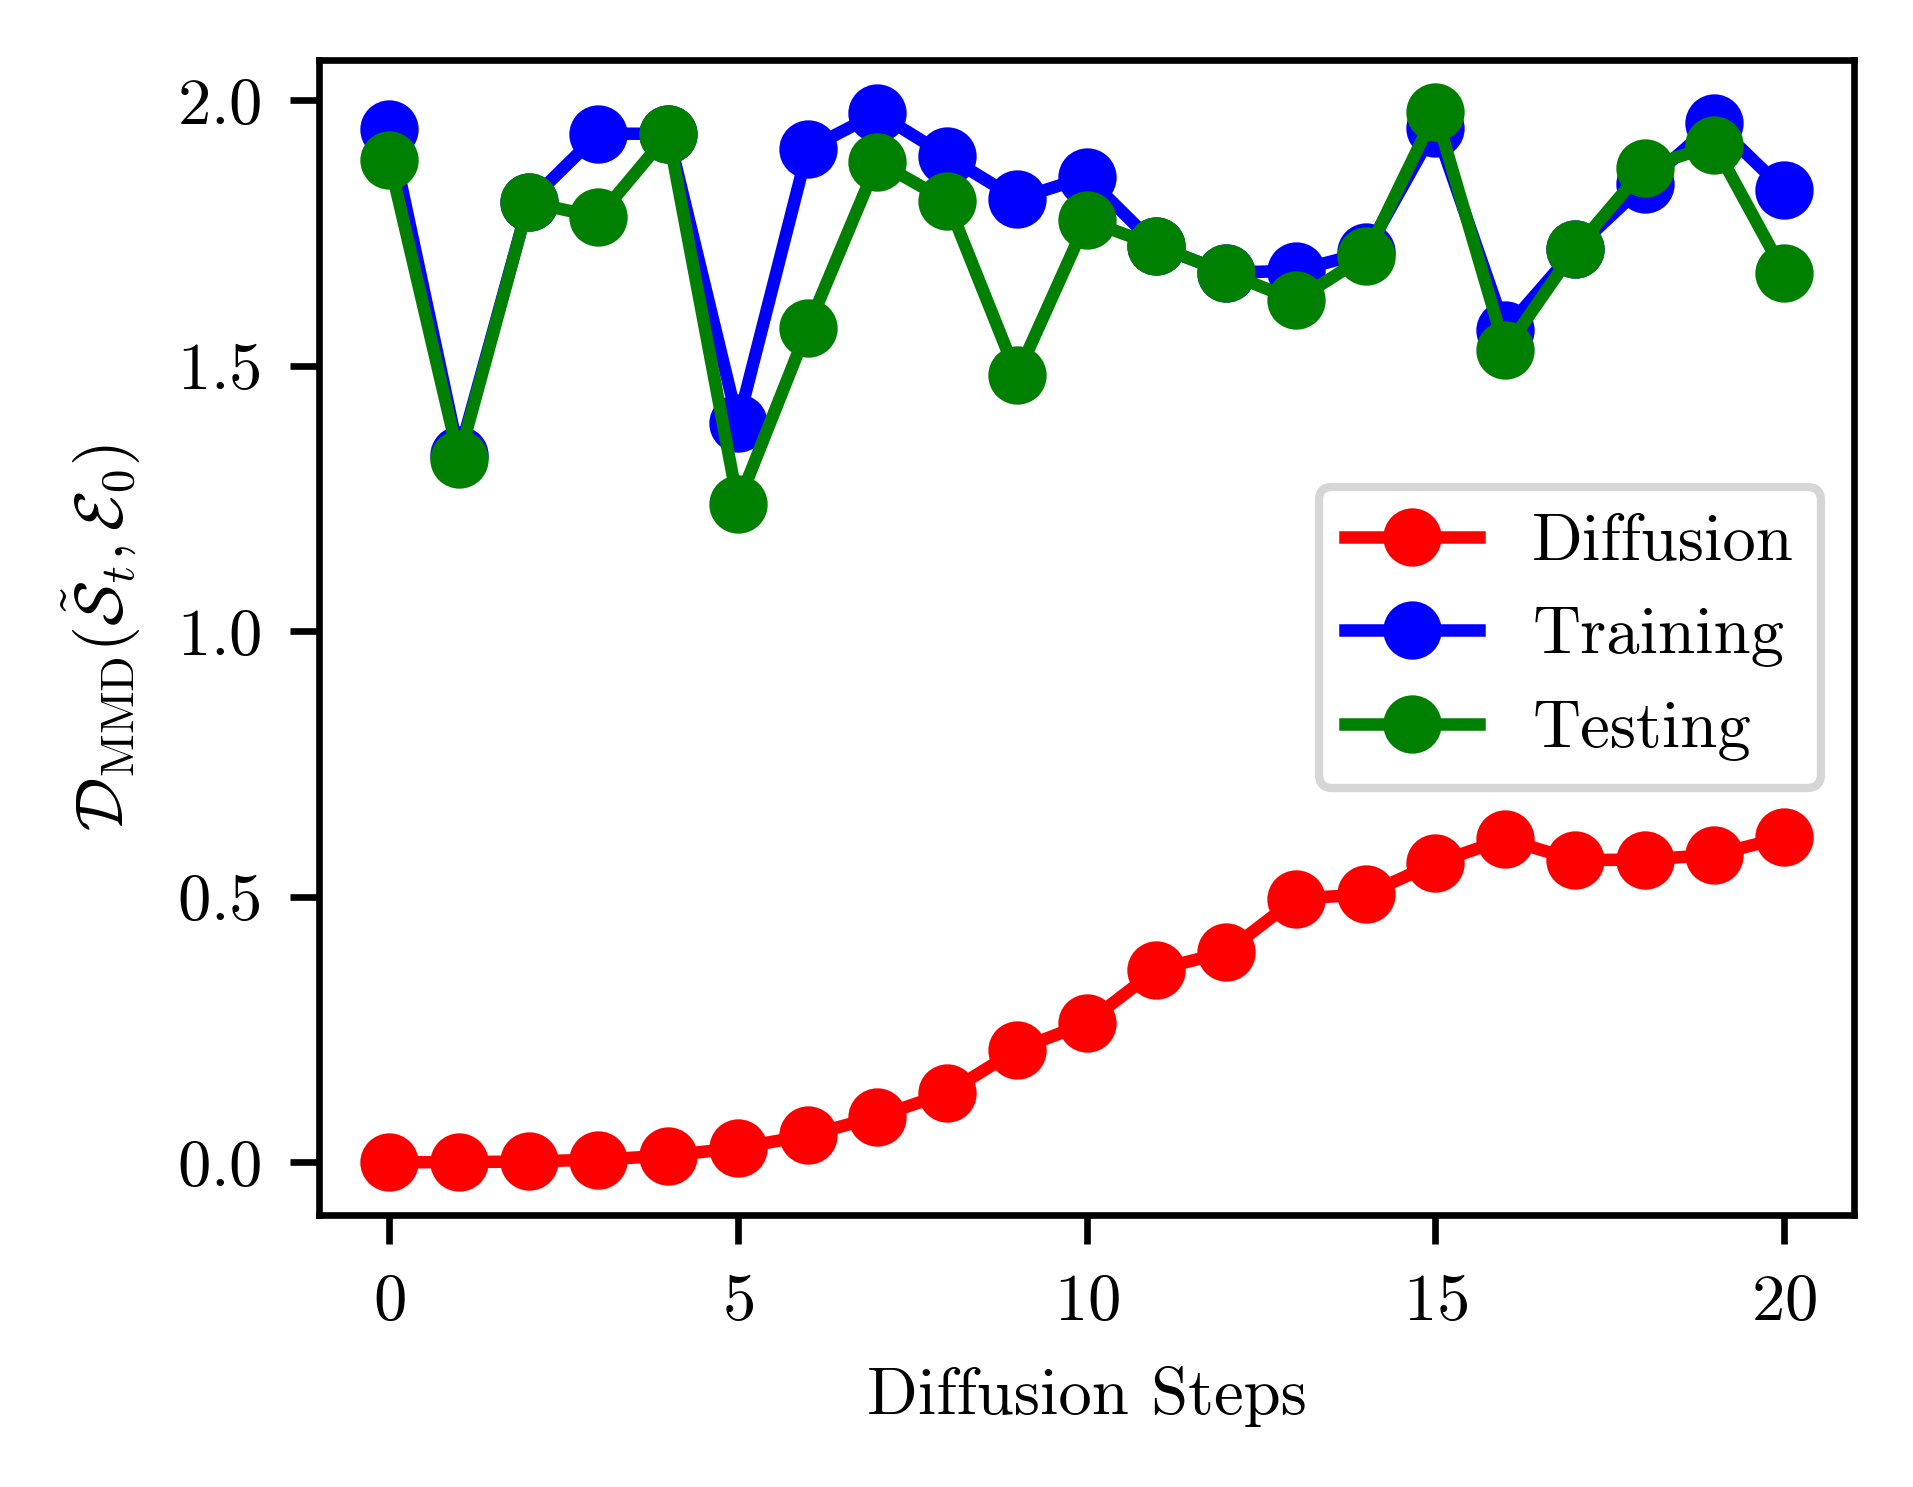

In [20]:
mmds = np.zeros((3, 21))
for t in range(21):
    idx = np.random.choice(S.shape[1], size=100, replace=False)
    mmds[0, t] = maxMeanDiscripency(S[0], S[t, idx])
    mmds[1, t] = maxMeanDiscripency(S[0], ApproxS[t])
    mmds[2, t] = maxMeanDiscripency(S[0], testS[t])

fig, ax = plt.subplots()
ax.plot(mmds[0], 'o-', c='r', label=r'Diffusion')
ax.plot(mmds[1], 'o-', c='b', label=r'Training')
ax.plot(mmds[2], 'o-', c='g', label=r'Testing')

ax.legend(loc = 'best')
ax.set_xlabel(r'Diffusion Steps')
ax.set_ylabel(r'$\mathcal{D}_{\rm MMD}(\tilde{\mathcal{S}}_t, \mathcal{E}_0)$')
#plt.savefig('Final-Clustering-DistanceInitial-1000epochs.pdf', bbox_inches='tight' )